## **Tutoriel sur l'explorateur spectroscropique dans l'ultraviolet lointain (FUSE)**

**Tutoriel:** Ce tutoriel explique comment ouvrir et modifier des fichiers FUSE FITS contenant des tables de données binaires, créer des spectrogrammes et analyser les données.

**Mission et instrument:** [Mission FUSE](https://www.asc-csa.gc.ca/fr/satellites/fuse.asp). Les données de ce tutoriel proviennent de l'instrument FUV (Far Ultraviolet)

**Objectif astronomique:** Ce tutoriel se concentre sur les naines blanches, en particulier WD0038+199. Il peut cependant être étendu à d'autres objets astronomiques, tels que les galaxies et les planètes.

**System requises:** l'accès à l'internet, Python v3.9 ou plus, Windows/MacOS/Linux

**Niveau du tutoriel:** Intermédiaire

---
**License MIT**  
  
Droit d’auteur (c) Sa Majesté le Roi du chef du Canada, représentée par l'Agence Spatiale Canadienne, 2024.

Copyright (c) His Majesty the King in Right of Canada, as represented by the Canadian Space Agency, 2024.

Pour plus de information, veuillez consulter le fichier License.txt

---  
**À propos du projet FUSE**  

L'explorateur spectroscopique dans l'ultraviolet lointain (FUSE) est le fruit d'une collaboration entre l'Agence spatiale canadienne (ASC), la NASA, le Centre national d'études spatiales (CNES) et l'Université Johns Hopkins. L'Université du Colorado à Boulder et l'Université de Californie à Berkeley ont également participé au projet. FUSE a été lancé le 24 juin 1999 et a fonctionné jusqu'au 18 octobre 2007. Pendant cette période, FUSE a observé près de 3000 objets astronomiques différents, accumulant un total de 64 millions de secondes d'observation réussie.

Pour en savoir plus sur la mission générale, consultez le site suivant: https://archive.stsci.edu/fuse/overview.html


**À propos le mission**  

L'objectif de cette mission était de réaliser diverses expériences scientifiques avec une précision jamais atteinte auparavant dans la bande de l'ultraviolet (UV). L'atmosphère terrestre, en particulier la thermosphère, absorbe les rayons UV, rendant ainsi les observations depuis le sol presque impossibles. Cela a poussé les scientifiques à développer des télescopes pouvant être envoyés dans l'espace, afin de capter les rayons UV et d'étudier une grande variété de sujets couvrant une gamme étendue de caractéristiques observées (i.e. [FUSE Magellanic Clouds Legacy Project](https://archive.stsci.edu/prepds/fuse_mc/)) dans les objets célestes jusqu'aux atlas des objets célestes (par exemple [FUSE Atlas of Starburst Galaxies](https://archive.stsci.edu/prepds/fuse_galaxies/)). L'une des missions principales était d'étudier le deutérium (D / D-I) ou l'hydrogène-II dans l'univers local.

Pour en savoir plus sur les objectifs scientifiques de premier plan et les résumés, consultez le site suivant : https://archive.stsci.edu/fuse/scisumm/

Basé sur des observations faites avec le NASA-CNES-CSA Explorateur Spectroscopique de l'Ultraviolet Lointain. FUSE est opéré pour le NASA par l'Université Johns Hopkins sous le contrat NASA NAS5-32985.  

In [1]:
## Importer des bibliothèques ##

#Pour importer des données à partir d'images FITS
import os
from astropy.io import fits
from astropy.table import Table

#Pour le traitement et l'analyse des données
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sps
import copy
from math import floor
from scipy.fft import rfft, irfft
from scipy.interpolate import CubicSpline
from scipy.stats import binned_statistic

#Pour créer la carte du ciel
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from imageio.v2 import imread

#Pour la barre de couleur
from matplotlib.colors import Normalize
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D


Note : La spectroscopie astronomique nécessite souvent une vérification manuelle. Il est recommandé à l'utilisateur de suivre le tutoriel en utilisant le même fichier ou la même cible avant d'expérimenter avec d'autres cibles. Pour d'autres cibles, l'utilisateur pourrait avoir besoin d'ajuster la région du détecteur qu'il examine afin de nettoyer ou d'analyser correctement les données.

Vous pouvez trouver ce fichier dans le CCDA sous l'ID de programme : P1040201.

### Importer les fichiers

Il existe deux approches pour obtenir des fichiers FUSE   
(1) Avec le [CCDA](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/fr/fuse/)     
(2) Avec le [MAST archive](https://archive.stsci.edu/fuse/) 

Le Centre canadien de données astronomiques (CCDA) permet aux utilisateurs de sélectionner facilement la cible souhaitée et les filtres spécifiés. 
- Allez sur [le site de CCDA](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/fr/fuse/) et filtrez pour les données FUSE.
- Choisissez les spécifications souhaitées et cliquez sur « Recherche ».
- Une liste s'affiche, dans laquelle vous pouvez sélectionner et télécharger les fichiers. Une option permet également de prévisualiser les données.
*Remarque : cette opération télécharge un fichier .tar qui doit être extrait avant d'accéder à tous les fichiers (voir « Extraction des fichiers .tar » ci-dessous).

Le Mikulski Archive for Space Telescopes (MAST) héberge les données archivées et le site web de FUSE, qui comprend des manuels de données et des informations techniques sur la mission. Vous pouvez consulter le site ici: https://archive.stsci.edu/fuse/.   
Pour télécharger les fichiers nécessaires: 
- En utilisant la barre latérale gauche, naviguez jusqu'à l'onglet « About FUSE Data ». Une fenêtre contextuelle s'affiche, et vous pouvez cliquer sur « Retrieve FUSE Data ».
- Sous le sous-titre « Retrieving from the anonymous ftp area », cliquez sur [le lien archive](https://archive.stsci.edu/pub/fuse/data/) à la fin du paragraphe.
- Une liste de dossiers s'affiche avec le nom de la cible et le temps d'exposition..
- Reportez-vous au [guide de dénomination des fichiers](https://archive.stsci.edu/fuse/DH_Final/Science_Data_Files.html#SECTION00712000000000000000) dans le manuel de données et recherchez le dossier contenant votre cible.
- Pour les besoins de ce tutoriel, téléchargez un fichier se terminant par "...all4ttagfcal.fit" ou "...all4histfcal.fit".
*Remarque : cette opération permet de télécharger un seul fichier FIT.

Sur la page de la mission FUSE, un manuel de données et un manuel d'instruments sont disponibles sous « Documentation ».  
Le manuel des données: https://archive.stsci.edu/fuse/dh.html  
Le manuel d'instruments: https://archive.stsci.edu/fuse/ih.html  

#### Extraction de fichiers Tar  

Pour extraire les fichiers de l'archive tar, commencez par créer un nouveau dossier ou exécutez le bloc de code ci-dessous. Si vous choisissez de créer votre propre dossier, n'oubliez pas de renommer le chemin d'extraction ci-dessous. Ensuite, faites simplement un clic droit sur l'archive tar, sélectionnez « Extraire tout... », et enregistrez les fichiers dans le nouveau dossier.

In [2]:
#Cela créera un dossier pour vos fichiers FUSE extraits s'il n'existe pas déjà.

extract_foldername = 'Extracted FUSE Files'
extract_path = os.path.realpath(extract_foldername)

if not os.path.exists(extract_path):
    os.mkdir(extract_path)

#Ou si vous créez votre dossier
#extract_path = "votre chemin d'accès au fichier ici"

### Vérifier l'utilisabilité des données
Certains fichiers ne contiendront pas de données en raison d'erreurs instrumentales ou de traitement. Utilisez le code suivant pour vérifier les commentaires dans l'en-tête, qui indiqueront si les données sont exploitables. Un exemple de commentaire indiquant des données inutilisables est ci-dessous :

Nom du fichier : m90055020011asic4ttagfcal.fit | Commentaire :
Détecteur à la tension SAA tout au long de l'exposition
CalFUSE v3.2.2 2008-05-14

Aucune donnée valide. Les tableaux de sortie sont définis sur zéro.
CalFUSE v3.2.2 2008-05-14

In [18]:
#Vérifiez si les données sont exploitables
for root, dirs, files in os.walk(extract_path):
    for filename in files: 
        if filename.endswith("4ttagfcal.fit"):
            try:
                file = os.path.join(root, filename)
                hdu = fits.open(file)
                Comment = hdu[0].header["COMMENT"]
                print (f"File Name: {filename} | Commentaire: {Comment}")
                hdu.close()
            except:
                print ("Ce fichier ne contient aucune donnée")

File Name: p104020100000all4ttagfcal.fit | Commentaire: 
Index to file extensions:
Extension 0   This Header
Extension 1   1ALIF
Extension 2   1BLIF
Extension 3   2BLIF
Extension 4   2ALIF
Extension 5   1ASIC
Extension 6   1BSIC
Extension 7   2BSIC
Extension 8   2ASIC

File Name: p104020100000ano4ttagfcal.fit | Commentaire: 
Index to file extensions:
Extension 0   This Header
Extension 1   1ALIF
Extension 2   1BLIF
Extension 3   2BLIF
Extension 4   2ALIF
Extension 5   1ASIC
Extension 6   1BSIC
Extension 7   2BSIC
Extension 8   2ASIC

Ce fichier ne contient aucune donnée
File Name: p104020100100all4ttagfcal.fit | Commentaire: 
This file contains no data.
Its header keywords are used by the DADS cataloging software.
CalFUSE v3.2.1   2007-11-21

Ce fichier ne contient aucune donnée
Ce fichier ne contient aucune donnée


### Création du spectrogramme  

Pour commencer, nous allons examiner un fichier unique et extraire les longueurs d'onde et les flux enregistrés. Nous souhaitons utiliser les fichiers "all4ttagfcal.fit" ou "all4histfcal.fit" car ils contiennent les données de tous les détecteurs. La nomenclature des détecteurs fait référence au capteur par lequel les données ont été capturées (LiF ou SiC) et du côté où elles ont été capturées (A ou B). Ces détecteurs ne peuvent accepter qu'une gamme limitée, mais lorsqu'ils sont combinés, ils créent le spectre UV complet. C'est un bon point de départ pour un débutant.

---
**Spectrogrammes**  
Un spectrogramme (celui utilisé en astronomie, à ne pas confondre avec les spectrogrammes sonores ou les sonogrammes) est un graphique représentant les longueurs d'onde contre leur flux mesuré. Cela s'appelle également un spectre stellaire. Tous les objets émettant de la lumière peuvent être analysés à l'aide d'un spectrogramme, ce qui permet de révéler leur composition chimique. L'apparence exacte du spectrogramme dépend de la gamme de lumière que vous examinez, de la présence de filtres sur la caméra permettant uniquement à certains éléments de passer, et de la précision de l'équipement utilisé

Filename: p104020100000all4ttagfcal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     378   ()      
  1  1ALIF         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   
  2  1BLIF         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   
  3  2BLIF         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  4  2ALIF         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  5  1ASIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  6  1BSIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  7  2BSIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  8  2ASIC         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   


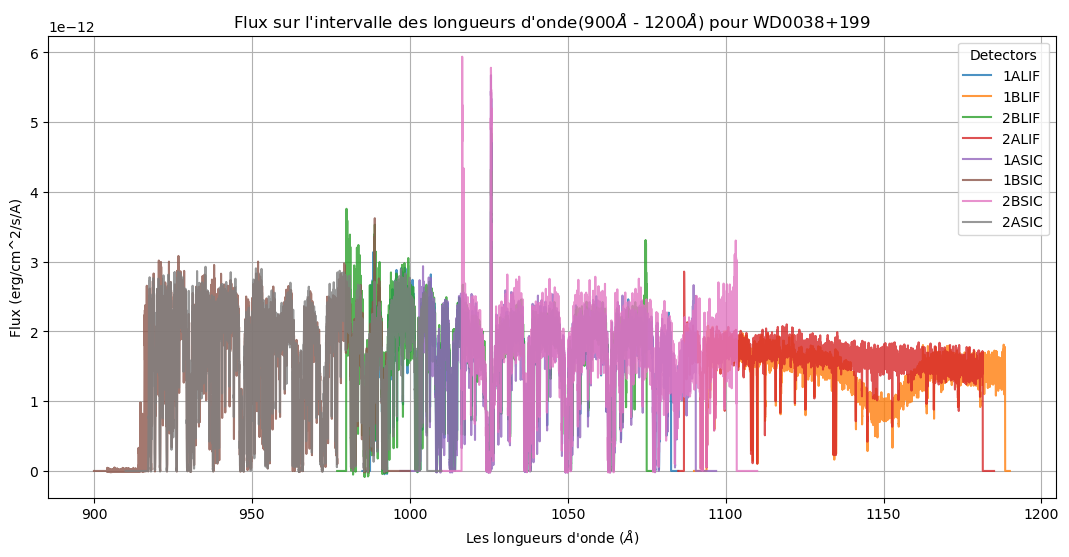

In [4]:
# Entrez le nom du fichier que vous souhaitez analyser
# Assurez-vous que le carnet Python se trouve au même emplacement que ce fichier

FileName = "p104020100000all4ttagfcal.fit"
hdu = fits.open(FileName)

# Afficher les informations de la liste HDU
hdu.info()

# Extraire RA, DEC et le nom de la cible depuis l'en-tête du fichier FITS
RA = hdu[0].header["RA_TARG"]
DEC = hdu[0].header["DEC_TARG"]
TargetName = hdu[0].header["TARGNAME"]

# Tracer les données
plt.figure(figsize = (13, 6))
SpectrumData = pd.DataFrame()
for index in range(1, len(hdu)):
    Detector = hdu[index].header["EXTNAME"]
    dict_hdu = {"Detector": Detector, "Wavelengths": Table(hdu[index].data)["WAVE"], "Flux": Table(hdu[index].data)["FLUX"]}
    SpectrumData = SpectrumData._append(dict_hdu, ignore_index= True)
    plt.plot(Table(hdu[index].data)['WAVE'], Table(hdu[index].data)['FLUX'], label = Detector, alpha = 0.8)

SpectrumData = SpectrumData.rename(index = SpectrumData['Detector'])
plt.legend(title = "Detectors")
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux sur l'intervalle des longueurs d'onde(900$\\AA$ - 1200$\\AA$) pour {TargetName}")
plt.show()
hdu.close()

### Nettoyage des données
Il y a deux principales caractéristiques que nous allons examiner et nettoyer : les émissions d'airglow et les « vers ».

#### Identifier et supprimer les émissions de l'airglow

L'airglow fait référence à la faible lueur présente dans la haute atmosphère terrestre, causée par l'excitation des molécules due au rayonnement électromagnétique émis par le Soleil. Étant donné que les détecteurs n'ont pas d'obturateur, les rayons provenant de cette lueur peuvent être capturés, apparaissant sous forme de raies d'émission dans le spectre stellaire. Ces raies sont mentionnées sur le site web de la mission FUSE comme une mise en garde à surveiller. Dans le cadre de la recherche, la vérification et la suppression des raies d'airglow sont des processus complexes. Toutefois, pour ce tutoriel, nous identifierons les raies à l'aide d'une liste prédéterminée et corrigerons les spectres de manière basique. Vous pouvez en apprendre davantage sur les émissions d'airglow en consultant [cliquez ici pour le site par l'équipe FUSE](https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001010000000000000000) et [cliquez ici pour le site par la NASA](https://earthobservatory.nasa.gov/images/147122/aurora-meet-airglow). Il convient de noter que les émissions d'airglow sont fortement corrélées à la série de Lyman.

**Données Jour + Nuit vs. Données Nuit Seulement**   

Les données du télescope provenant du cycle orbital Jour + Nuit comportent un risque d'inclure des émissions d'airglow provenant de la Terre, tandis que le cycle orbital Nuit Seulement évite cela complètement. Il y a une valeur dans les données du cycle Jour + Nuit, c'est pourquoi nous les prenons toujours en compte. En général, les données Jour + Nuit et Nuit Seulement suivent des tendances similaires, nous allons donc réduire l'airglow en traitant cette région comme si elle était des données Nuit Seulement. 

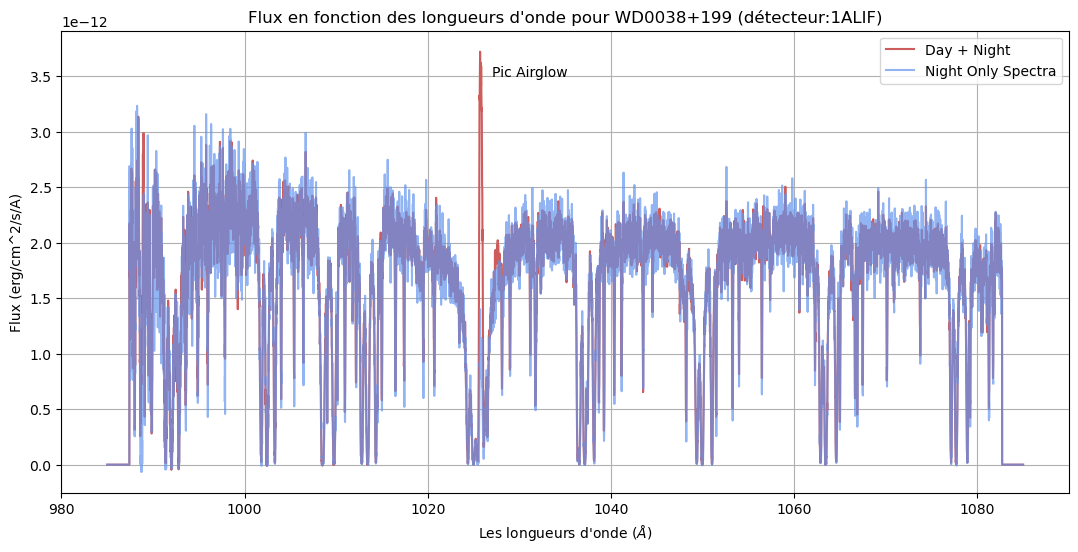

In [5]:
for root, dirs, files in os.walk(extract_path):
    for filename in files: 
        if filename.endswith("ano4ttagfcal.fit"):
            file = os.path.join(root, filename)
            hdu = fits.open(file)
            DataTable_Night = Table(hdu[1].data) 
            Wavelengths_Night = DataTable_Night["WAVE"]
            Flux_Night = DataTable_Night["FLUX"]

#Par simplicité
Wavelengths_1ALiF = SpectrumData.loc["1ALIF", "Wavelengths"]
Flux_1ALiF = SpectrumData.loc["1ALIF", "Flux"]
Detector_1ALiF = SpectrumData.loc["1ALIF", "Detector"]

#Créer un graphique général du flux en fonction des longueurs d'onde
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, Flux_1ALiF, color = 'indianred', label = "Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = 'cornflowerblue', alpha = 0.7, label = "Night Only Spectra")
plt.text(1027, 3.5e-12, "Pic Airglow")
plt.grid(True)
plt.legend()
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux en fonction des longueurs d'onde pour {TargetName} (détecteur:{Detector_1ALiF})")
plt.show()

Comme on peut le voir ici, il y a une divergence entre les données collectées pendant le cycle Jour + Nuit et celles collectées pendant le cycle Nuit Seulement. Dans l'ensemble, les spectres combinés montrent une tendance générale sans trop de valeurs aberrantes, mais là où le cycle Jour + Nuit présente un pic significatif, il y a un point de préoccupation. Cela indique la présence d'airglow qui doit être corrigé. Nous pouvons accomplir cela en supprimant la région d'airglow et en la remplaçant par les données du cycle Nuit Seulement, car les tendances du cycle Jour + Nuit et Nuit Seulement sont très similaires.

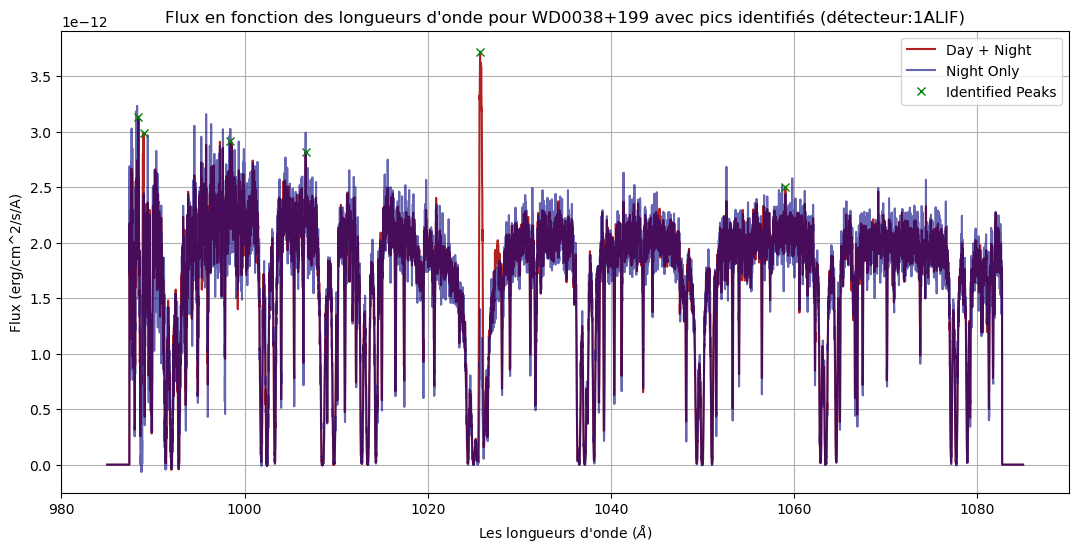

Airglow line 1025.72 for wavelength 1025.7099609375
Airglow line 1025.76 for wavelength 1025.7099609375
The following wavelength(s) is/are airglow peak(s): [1025.71]


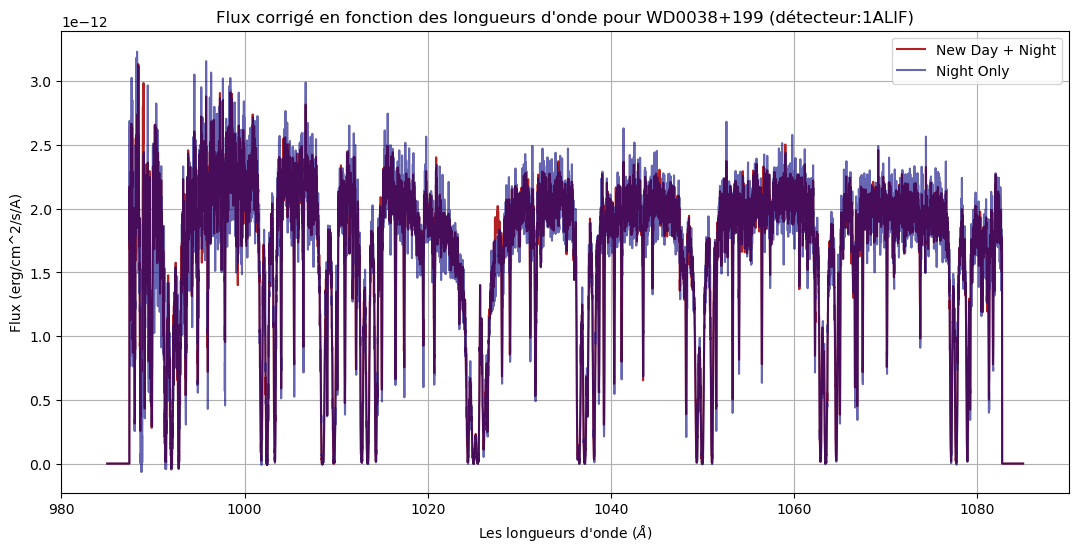

In [6]:
#Commencez par déterminer les pics du spectre
peaks, _ = sps.find_peaks(Flux_1ALiF, prominence=2.5e-12)

#Tracer les données et les pics
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, Flux_1ALiF, color = "firebrick", label = "Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = "navy", alpha = 0.6, label = "Night Only")
plt.plot(Wavelengths_1ALiF[peaks], Flux_1ALiF[peaks], "x", color = "green", label = "Identified Peaks")
plt.grid(True)
plt.legend()
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux en fonction des longueurs d'onde pour {TargetName} avec pics identifiés (détecteur:{Detector_1ALiF})")
plt.show()

#Longueurs d'onde où l'airglow est fortement susceptible de se produire :
AirglowLines = [926.23, 930.74, 937.8, 949.74, 972.54, 988.77, 990.20, 1025.72, 1025.76, 1027.43, 1039.23, 1040.94]

def flux_change(Wavelengths, Wave_Night, Flux, Flux_Night, peaks):
    """
    Removes the airglow region and returns the new flux
    Inputs:
    - Wavelengths (numpy array or astropy column): Wavelengths from the Day + Night spectrum
    - Wave_Night (numpy array or astropy column): Wavelengths from the Night Only spectrum
    - Flux (numpy array or astropy column): Flux from the Day + Night spectrum
    - Flux_Night (numpy array or astropy column): Flux from the Night Only spectrum
    - peaks (numpy array): Array containing the indices/locations of the peaks in the Day + Night spectrum

    Returns: 
    - New_Flux (astropy column): New flux of the Day + Night spectrum without the significant airglow emission 
    """
    New_Flux = copy.copy(Flux)
    
   #Déterminer la longueur d'onde au pic déterminé
    WavePeaks = np.array(Wavelengths[peaks])

    #Déterminer quels des pics sont corrélés à une raie d'airglow
    WavetoAirglow = []
    for j in AirglowLines:
        for i in WavePeaks:
            if j + 0.1 >= i and j - 0.1 <= i: #the tolerence is quite small here but can be adjusted accoordingly(?)
                print (f"Airglow line {j} for wavelength {i}")
                WavetoAirglow.append(i)
    WavetoAirglow = list(set(WavetoAirglow))
    print (f"The following wavelength(s) is/are airglow peak(s): {WavetoAirglow}")
    
   #Déterminer l'emplacement des longueurs d'onde qui sont prouvées comme étant corrélées à une raie d'airglow
    AirglowPeaks = []
    AirglowPeaks_Night = []
    for i in WavetoAirglow: 
        x = np.where(i == Wavelengths)[0][0]
        y = np.where(i == Wave_Night)[0][0]
        AirglowPeaks.append(x)
        AirglowPeaks_Night.append(y)

   #Modifier la valeur du flux pour qu'elle corresponde à la valeur de la nuit
    for i in AirglowPeaks:
        for j in AirglowPeaks_Night:
            if New_Flux[i] > Flux_Night[j]:
                New_Flux[i-30:i+30] = Flux_Night[j-30:j+30]
    return New_Flux

NewFlux = flux_change(Wavelengths_1ALiF, Wavelengths_Night, Flux_1ALiF, Flux_Night, peaks)


#Tracer le flux corrigé
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, NewFlux, color = "firebrick", label = "New Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = "navy", alpha = 0.6, label = "Night Only")
plt.grid(True)
plt.legend()
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux corrigé en fonction des longueurs d'onde pour {TargetName} (détecteur:{Detector_1ALiF})")
plt.show()

Maintenant que l'airglow a été corrigé, nous pouvons interpoler les données et trouver la moyenne entre les deux ensembles de données afin d'obtenir une meilleure vue du spectre UV.

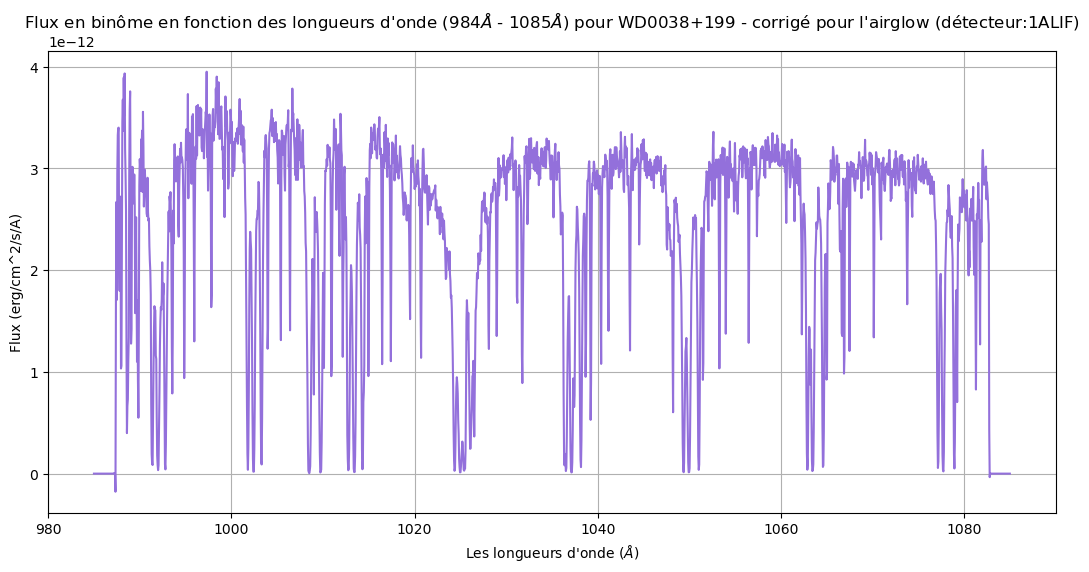

In [7]:
#Regrouper les données (Binner les données)
stats_newflux, _, __ = binned_statistic(Wavelengths_1ALiF, NewFlux, bins = (floor(len(NewFlux)/3)))
stats_night, _, __ = binned_statistic(Wavelengths_Night, Flux_Night, bins = (floor(len(Flux_Night)/3)))
xvals_newflux = np.linspace(min(Wavelengths_1ALiF), max(Wavelengths_1ALiF), num = (floor(len(NewFlux)/3)))
xvals_night = np.linspace(min(Wavelengths_Night), max(Wavelengths_Night), num = (floor(len(Flux_Night)/3)))

#Ajuster à l'aide d'un spline cubique
spl_NewFlux = CubicSpline(xvals_newflux, stats_newflux)
spl_Night = CubicSpline(xvals_night, stats_night)
xvals = np.linspace(min(Wavelengths_1ALiF), max(Wavelengths_1ALiF), num = 2000)
SplineAvg_AG = spl_NewFlux(xvals) + spl_Night(xvals) / 2

plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG, color = 'mediumpurple')
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux en binôme en fonction des longueurs d'onde ({int(min(Wavelengths_1ALiF))}$\\AA$ - {int(max(Wavelengths_1ALiF))}$\\AA$) pour {TargetName} - corrigé pour l'airglow (détecteur:{Detector_1ALiF})")
plt.show()

**Splines Cubiques**  
Un spline est un ensemble de fonctions polynomiales par morceaux qui peuvent être utilisées pour interpoler et regrouper des données. Un spline cubique fait spécifiquement référence à un ensemble de fonctions où le degré le plus élevé est 3. Ceux-ci sont préférés aux splines linéaires parce que les splines cubiques sont plus précises et permettent une meilleure visualisation des données.

#### Corriger pour les "Worms"
Les "Worms" est le terme utilisé par l'équipe FUSE pour décrire le phénomène où les fils de la grille des détecteurs FUSE projettent une ombre, ce qui entraîne une diminution artificielle du flux. Vous pouvez en apprendre davantage sur ce sujet en consultant [ici par l'équipe FUSE](https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001032000000000000000). Afin de corriger ce phénomène, nous comparons les données recueillies dans cette région avec d'autres données et appliquons un processus similaire à celui utilisé pour les émissions d'airglow.

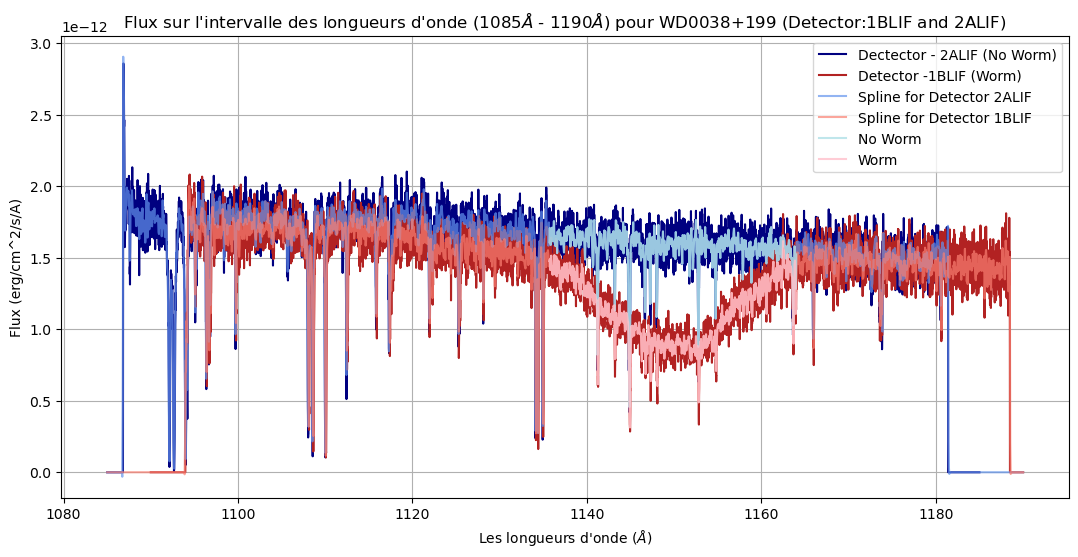

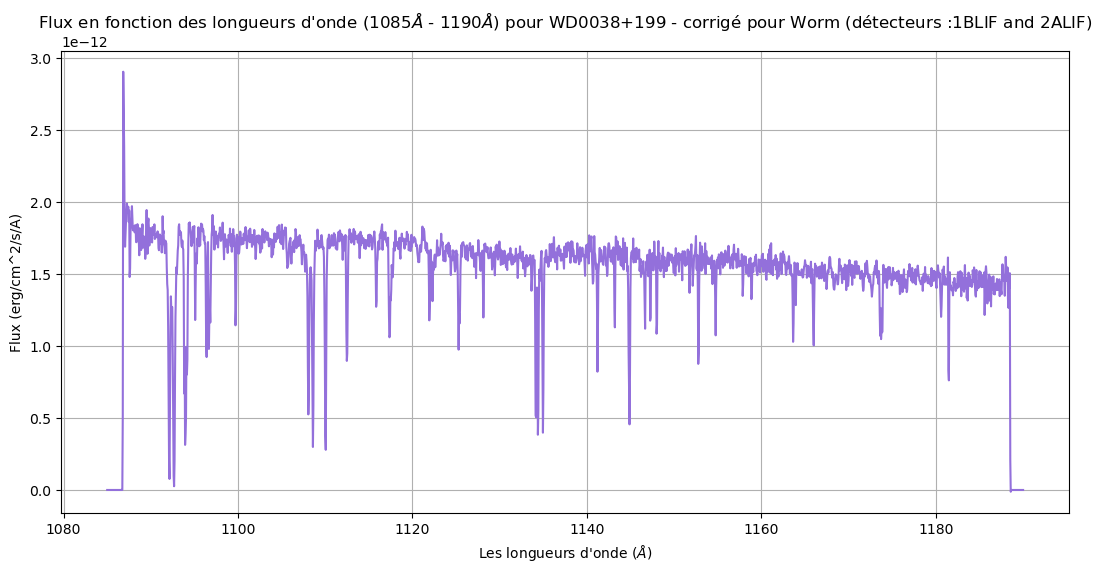

In [8]:
#Par simplicité
Wavelengths_1BLiF = SpectrumData.loc['1BLIF', "Wavelengths"]
Flux_1BLiF = SpectrumData.loc['1BLIF', 'Flux']
Detector_1BLiF = SpectrumData.loc['1BLIF', 'Detector']

Wavelengths_2ALiF = SpectrumData.loc['2ALIF', "Wavelengths"]
Flux_2ALiF = SpectrumData.loc['2ALIF', 'Flux']
Detector_2ALiF = SpectrumData.loc['2ALIF', 'Detector']

#Déterminer l'emplacement du creux
flux_fft = rfft(np.array(Flux_1BLiF))
ten_len = floor((len(flux_fft)) * 0.01)
flux_fft[ten_len:] = 0.0
flux_inv = irfft(flux_fft)

dips,__ = sps.find_peaks(-flux_inv, prominence=0.5e-12)

#Regrouper les données pour éliminer le bruit indésirable et les valeurs aberrantes
stats_1BLiF, _, ___ = binned_statistic(Wavelengths_1BLiF, Flux_1BLiF, bins=(floor(len(Wavelengths_1BLiF)/3)))
stats_2ALiF, _, __ = binned_statistic(Wavelengths_2ALiF, Flux_2ALiF, bins=(floor(len(Wavelengths_2ALiF)/3)))

xvals_1BLiF = np.linspace(min(Wavelengths_1BLiF), max(Wavelengths_1BLiF), num = (floor(len(Wavelengths_1BLiF)/3)))
xvals_2ALiF = np.linspace(min(Wavelengths_2ALiF), max(Wavelengths_2ALiF), num = (floor(len(Wavelengths_2ALiF)/3)))

##Trouver l'ajustement du spectre en utilisant un spline
spl_Worm = CubicSpline(xvals_1BLiF, stats_1BLiF)
spl_NoWorm = CubicSpline(xvals_2ALiF, stats_2ALiF)
x = np.linspace(min(Wavelengths_2ALiF), max(Wavelengths_1BLiF), num = 2000)

def determine_worm(x, Wave_Dip):
    """ 
    Determines the region where the worm is located
    Inputs: 
    - x (numpy array): linspace of x values used for interpolating
    - Wave_Dip (numpy array or astropy column): wavelength where the maximum dip is (i.e. the center of the worm)

    Returns
    - Index (int): midpoint location of the worm
    """
    loc_list = []
    for i in range(0, len(x)):
        if int(x[i]) == int(Wave_Dip):
            loc_list.append(i)
    loc_list.sort()
    mid_num = int(len(loc_list)/2)
    index = loc_list[mid_num]
    return (index)

##Trouver le spline moyen
SplineAverage = (spl_NoWorm(x) + spl_Worm(x))/2

#Corriger pour la moyenne des zéros
for i in range(0, len(spl_NoWorm(x))):
    if spl_NoWorm(x)[i] < 1e-15:
        SplineAverage[i] = spl_Worm(x)[i]
    elif spl_Worm(x)[i] < 1e-15:
        SplineAverage[i] = spl_NoWorm(x)[i]
    else:
        pass

index = determine_worm(x, Wavelengths_1BLiF[dips[0]])

#Remplacer les données
SplineAverage[abs(320 - index):index + 220] = spl_NoWorm(x)[abs(320 - index):index + 220]

#Créer un graphique général du flux en fonction des longueurs d'onde
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_2ALiF, Flux_2ALiF, label = f"Dectector - {Detector_2ALiF} (No Worm)", color = "navy")
plt.plot(Wavelengths_1BLiF, Flux_1BLiF, label = f"Detector -{Detector_1BLiF} (Worm)", color = "firebrick")

#Tracer le spline pour chacun d'eux
plt.plot(x, spl_NoWorm(x), label = f"Spline for Detector {Detector_2ALiF}", color = "cornflowerblue", alpha = 0.7)
plt.plot(x, spl_Worm(x), label = f"Spline for Detector {Detector_1BLiF}", color = "salmon", alpha = 0.7)

plt.plot(x[abs(320-index): 220+index], spl_NoWorm(x)[abs(320-index): 220+index], label = "No Worm", color = "powderblue", alpha = 0.8)
plt.plot(x[abs(320-index): 220+index], spl_Worm(x)[abs(320-index): 220+index], label = "Worm", color = "pink", alpha = 0.8)

plt.grid(True)
plt.legend(loc = "upper right")
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux sur l'intervalle des longueurs d'onde ({int(min(Wavelengths_2ALiF))}$\\AA$ - {int(max(Wavelengths_1BLiF))}$\\AA$) pour {TargetName} (Detector:{Detector_1BLiF} and {Detector_2ALiF})")
plt.show()

#Tracer la moyenne
plt.figure(figsize = (13, 6))
plt.plot(x, SplineAverage, color = 'mediumpurple')
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux en fonction des longueurs d'onde ({int(min(Wavelengths_2ALiF))}$\\AA$ - {int(max(Wavelengths_1BLiF))}$\\AA$) pour {TargetName} - corrigé pour Worm (détecteurs :{Detector_1BLiF} and {Detector_2ALiF})")
plt.show()

### Comprendre le Spectrogramme  
Pour comprendre ce que ce graphique nous montre, nous devons le comparer à des graphiques ou des tendances théoriques ou expérimentales acceptées. Comme discuté précédemment, en utilisant les prédictions des spectres d'émission, nous pouvons déterminer différentes caractéristiques et les utiliser pour des analyses plus approfondies.

Pour ce tutoriel, l'objectif est d'analyser le deutérium. Nous utiliserons cet article, [The D/H Ratio toward PG 0038+199](https://arxiv.org/pdf/astro-ph/0501320) (Williger et al., 2005) comme référence (notez que PG et WD font tous deux référence à des naines blanches). Il se concentre sur la détermination de l'emplacement du deutérium et fournit des références claires à ses différentes positions sur le spectrogramme.

**Signification du Deutérium**  

Le deutérium est un isotope de l'hydrogène, également connu sous le nom d'hydrogène-II, qui est extrêmement difficile à produire en raison des conditions extrêmes nécessaires. Un moment où ces conditions se sont produites est pendant le Big Bang, lorsque l'univers se formait. L'énergie était si élevée qu'elle a permis à l'H-I de devenir H-II, mais à mesure que l'univers se refroidissait, ces conditions ont disparu, laissant une quantité finie d'H-II ou de D-I dans l'univers. Il est toujours possible de le produire, mais comme mentionné, c'est extrêmement difficile et les processus naturels actuels produisent une quantité négligeable. Les objets célestes montrant des signes de deutérium permettent aux scientifiques de mieux comprendre les caractéristiques de la cible et les conditions de l'univers primitif.

Le deutérium peut également être trouvé dans nos océans et sa concentration varie selon les sources d'eau. En utilisant ces informations, les scientifiques peuvent déterminer la source de l'eau en fonction du pourcentage de deutérium, ce qui peut être utilisé pour des études sur la filtration ou les patterns de migration.


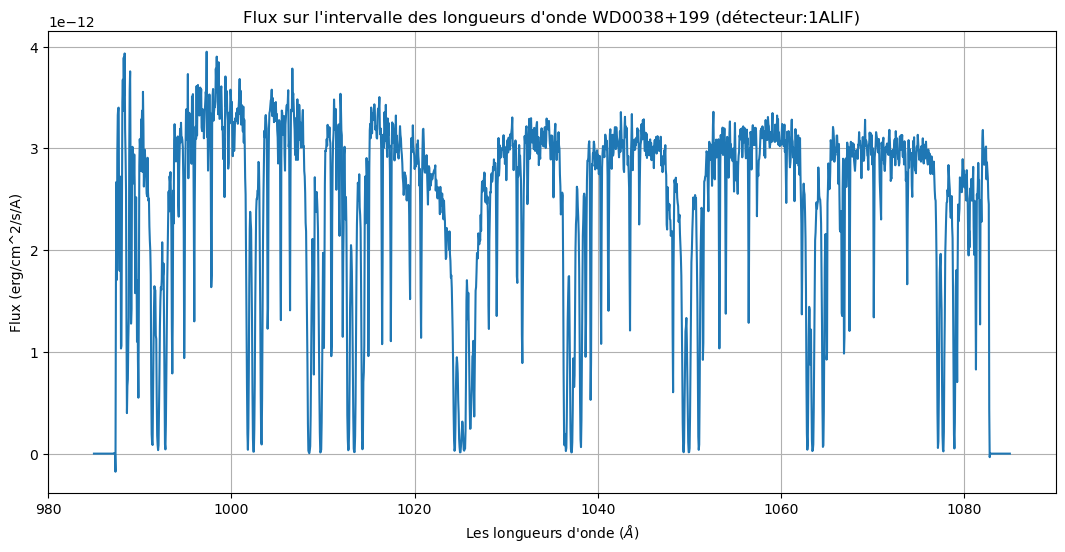

In [9]:
#Créer un graphique général du flux en fonction des longueurs d'onde
plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG)
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux sur l'intervalle des longueurs d'onde {TargetName} (détecteur:{Detector_1ALiF})")
plt.show()

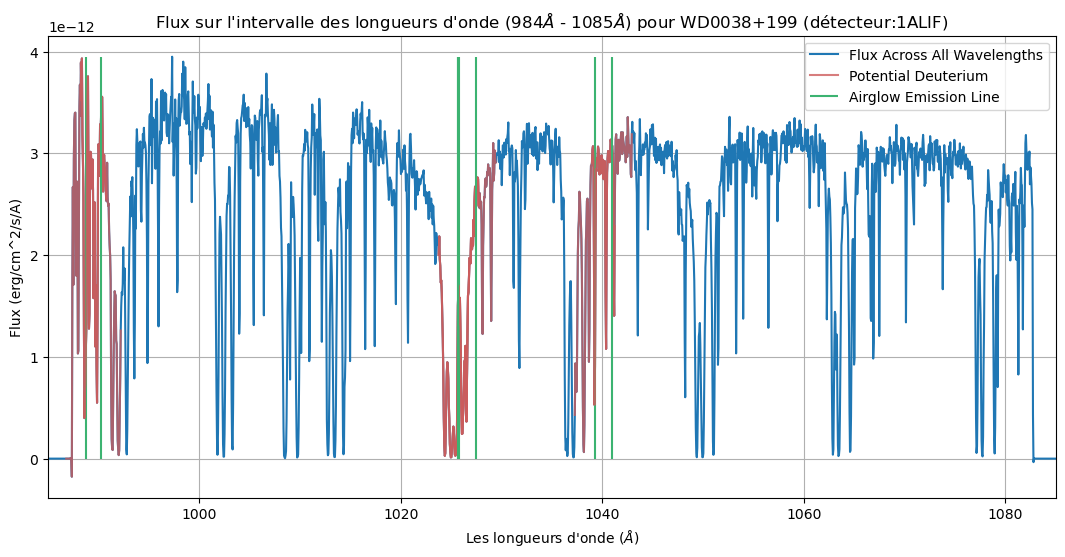

In [10]:
#Pour faciliter l'analyse, nous pouvons créer un nouveau dataframe séparé uniquement pour les données de ce spectre
wave = np.array(xvals)
flux = np.array(SplineAvg_AG)
Data_df = pd.DataFrame(np.transpose(np.array([wave, flux])), columns=['WAVE', 'FLUX'])

#Créer un graphique mettant en évidence toutes les régions qui contiennent potentiellement du deutérium
plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG, label = "Flux Across All Wavelengths")

for Lambda in AirglowLines:
    plt.plot(Data_df.query(f"WAVE > {Lambda - 2} and WAVE < {Lambda + 2}")["WAVE"], Data_df.query(f"WAVE > {Lambda - 2} and WAVE < {Lambda + 2}")["FLUX"], color = "indianred", alpha = 0.8)
    plt.vlines(Lambda, 0.0, max(flux), color = "mediumseagreen")

#Se concentrer sur la région spécifique de l'airglow autour de λ = 972,54 angströms
D_df = Data_df.query("WAVE > 1025.3 and WAVE < 1025.6")
D_df = D_df.reset_index(drop =True)
plt.plot(D_df['WAVE'], D_df["FLUX"], color = "indianred", alpha = 0.8, label = "Potential Deuterium")

#À des fins d'étiquetage
plt.vlines(1025.72, 0.0, max(flux), color = 'mediumseagreen', label = 'Airglow Emission Line')

plt.legend(loc = "upper right")
plt.xlim(min(xvals), max(xvals))
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux sur l'intervalle des longueurs d'onde ({int(min(wave))}$\\AA$ - {int(max(wave))}$\\AA$) pour {TargetName} (détecteur:{Detector_1ALiF})")
plt.show()

Comme nous pouvons le voir, il existe de nombreuses régions potentielles de deutérium. Nous allons nous concentrer sur une région particulière pour trouver des preuves exactes, tout en se référant à l'article mentionné plus haut de Williger et al.

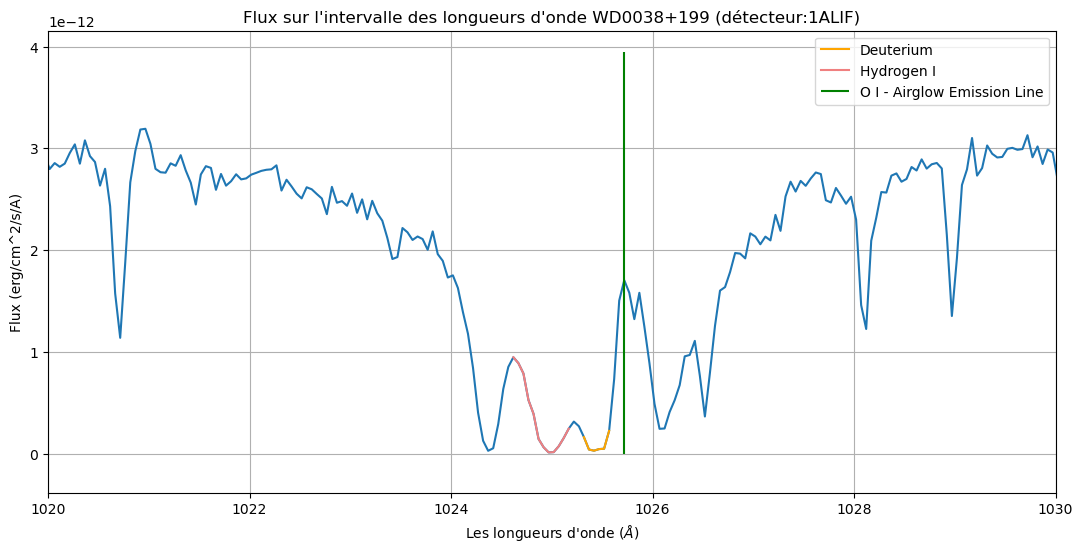

The maximum flux for deuterium in the region of emission line 1025.72 A is 2.908500135131509e-14 erg/cm^2/s/A


In [11]:
plt.figure(figsize = (13, 6))

#Extraire l'hydrogène dans son propre dataframe

H_df = Data_df.query("WAVE > 1024.6 and WAVE < 1025.2") #Ces valeurs ont été déterminées manuellement en analysant le graphique.

H_df = H_df.reset_index(drop =True)
plt.plot(Data_df["WAVE"], Data_df["FLUX"])
plt.plot(D_df['WAVE'], D_df["FLUX"], color = "orange", label = "Deuterium")
plt.plot(H_df['WAVE'], H_df["FLUX"], color = "lightcoral", label = "Hydrogen I")
plt.vlines(1025.72, 0, max(flux), color = "green", label = "O I - Airglow Emission Line")

plt.legend()
plt.xlim(1020, 1030)
plt.grid(True)
plt.xlabel("Les longueurs d'onde ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux sur l'intervalle des longueurs d'onde {TargetName} (détecteur:{Detector_1ALiF})")
plt.show()

#Extraire le deutérium
Deuterium = min(D_df['FLUX'])
print (f"The maximum flux for deuterium in the region of emission line 1025.72 A is {Deuterium} erg/cm^2/s/A")

Le deutérium est l'une des baisses d'absorption ici, ayant une largeur d'environ 0,2 angström. Sa petite taille montre la nécessité de niveaux élevés de précision dans les instruments pour comprendre de manière adéquate des isotopes tels que le deutérium.

La raison pour laquelle nous ne voyons pas le pic d'airglow est que ceci provient des données de la première section où ce pic a été supprimé.

### Tracer l'Intensité sur une Carte de l'Univers
Pour créer une meilleure visualisation de la concentration de deutérium, nous pouvons tracer la région sur une carte de l'univers avec une barre de couleur correspondante.


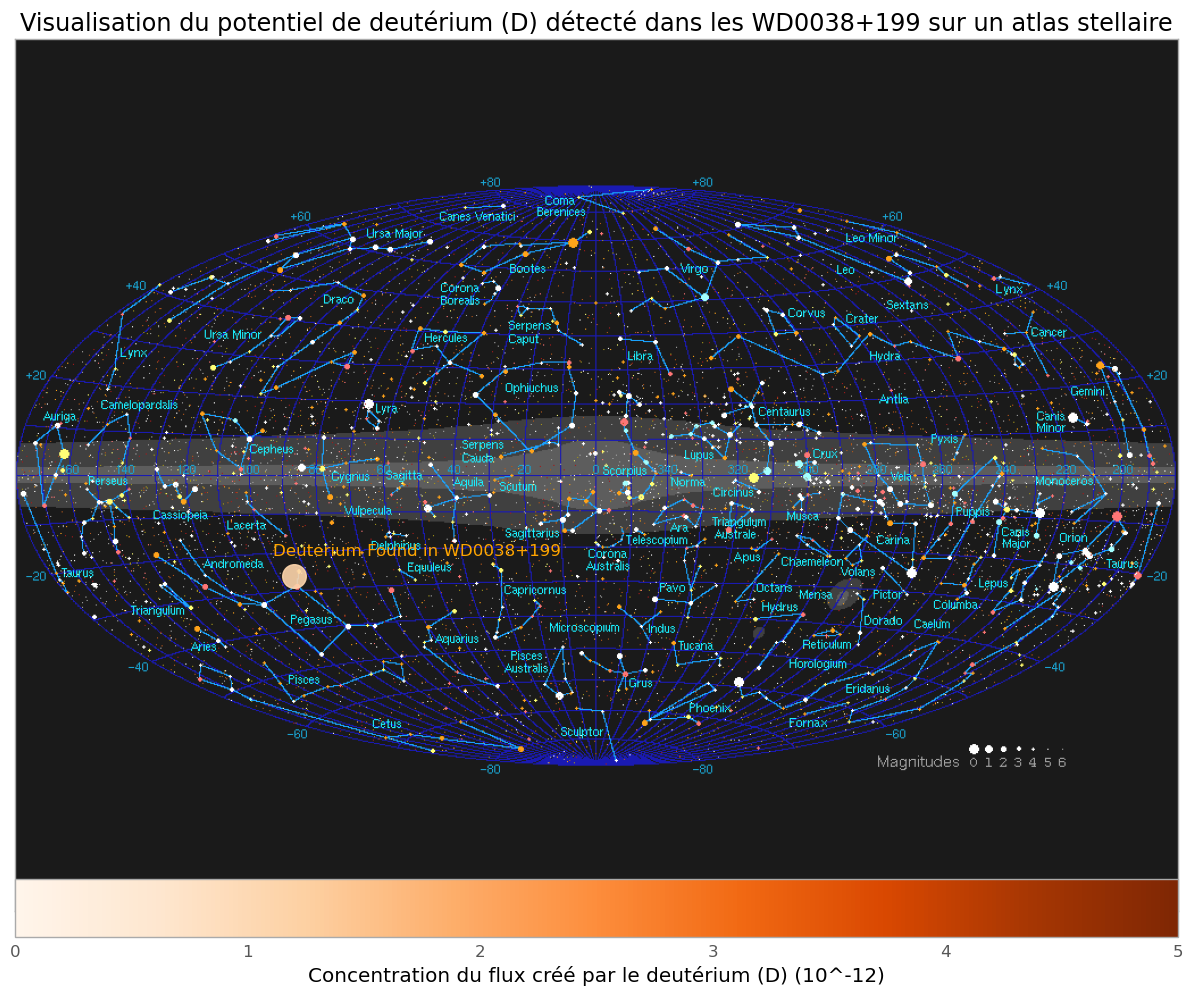

In [16]:
star_atlas_url = "http://www.atlasoftheuniverse.com/galchart.gif"

def convert_coords (ra):
    """ Converts the provided coordinate given in radians to be usable on a sky map for plotting. 
        Preferable for x-coordinate/longitude/right ascension. Y-coordinates/latitude/declination does not
        need to be converted. 

    :param ra: the provided right ascension coordinate in radians
    :type ra: float
    
    :returns ra_convert: the converted coordinates for right ascenion in radians
    :rtype ra_convert: float"""

    # Convertir l'ascension droite pour permettre qu'elle s'enroule autour de la carte
    ra_convert = 0
    if ra > (np.pi):
        ra_convert = -1 * ((ra % (np.pi)) - (np.pi)) 
    else:
        ra_convert = -1 * ra
    
    return (ra_convert)

img = imread(star_atlas_url)
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(img, alpha = 0.9)

ax2 = fig.add_subplot(projection = "aitoff")

#Implémenter l'objet et convertir en unités galactiques
object = SkyCoord(RA, DEC, unit = 'deg')
object_ra = (convert_coords(object.galactic.l.rad))
object_dec = object.galactic.b.rad

max_wave = D_df["WAVE"][np.where(max(D_df["FLUX"]) == D_df["FLUX"])[0][0]]
d = {"Max Wave": max_wave, "Max Flux": max(D_df["FLUX"]), "RA": object_ra, "DEC": object_dec, "Star Name": TargetName}
df = pd.DataFrame()
df = df._append(d, ignore_index = True)

#Placer le object
cmap = plt.colormaps["Oranges"]
ax2.plot(object_ra, object_dec, marker = 'o', markersize = 17, color = cmap(df["Max Flux"][0] * 1e12), alpha = 0.9)
ax2.text(object_ra, object_dec + 0.1, "Deuterium Found in " + df["Star Name"][0], color = "orange") #Add name of the star
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0,  5), cmap=cmap), ax = ax2, location = "bottom", orientation = "horizontal", label = "Concentration du flux créé par le deutérium (D) (10^-12)")

plt.axis("off")
ax.grid(False)
ax.set_title("Visualisation du potentiel de deutérium (D) détecté dans les " + df["Star Name"][0] + " sur un atlas stellaire")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Étendons cela à plusieurs objets pour observer les concentrations contrastées.
Pour ce faire, sélectionnez et téléchargez un autre dossier contenant des données sur un objet différent. Combinez ces deux fichiers dans un seul dossier pour l'analyse.

File Name: m105121100000all4histfcal.fit
File Name: m717070200000all4ttagfcal.fit
File Name: m727210100000all4ttagfcal.fit
File Name: p104020100000all4ttagfcal.fit
File Name: u102070200000all4ttagfcal.fit
White Dwarf Dataframe
      Max Wave      Max Flux        RA       DEC   Star Name  \
0   987.425049  3.217006e-13  0.525669 -0.122482  WD1634-573   
1  1025.775024  5.105608e-14  1.368000 -0.410026  WD0715-704   
2   991.234009  1.166855e-13 -1.942462  0.586063  WD1631+781   
3  1025.709961 -1.181569e-14 -2.090703 -0.744510  WD0038+199   
4   984.994019  0.000000e+00 -2.601463  0.374315  WD0615+655   

                                         Wavelengths  \
0  1155    1000.009033
1156    1000.022034
1157  ...   
1  1155    1000.009033
1156    1000.022034
1157  ...   
2  1155    1000.009033
1156    1000.022034
1157  ...   
3  1155    1000.009033
1156    1000.022034
1157  ...   
4  1155    1000.009033
1156    1000.022034
1157  ...   

                                                Flu

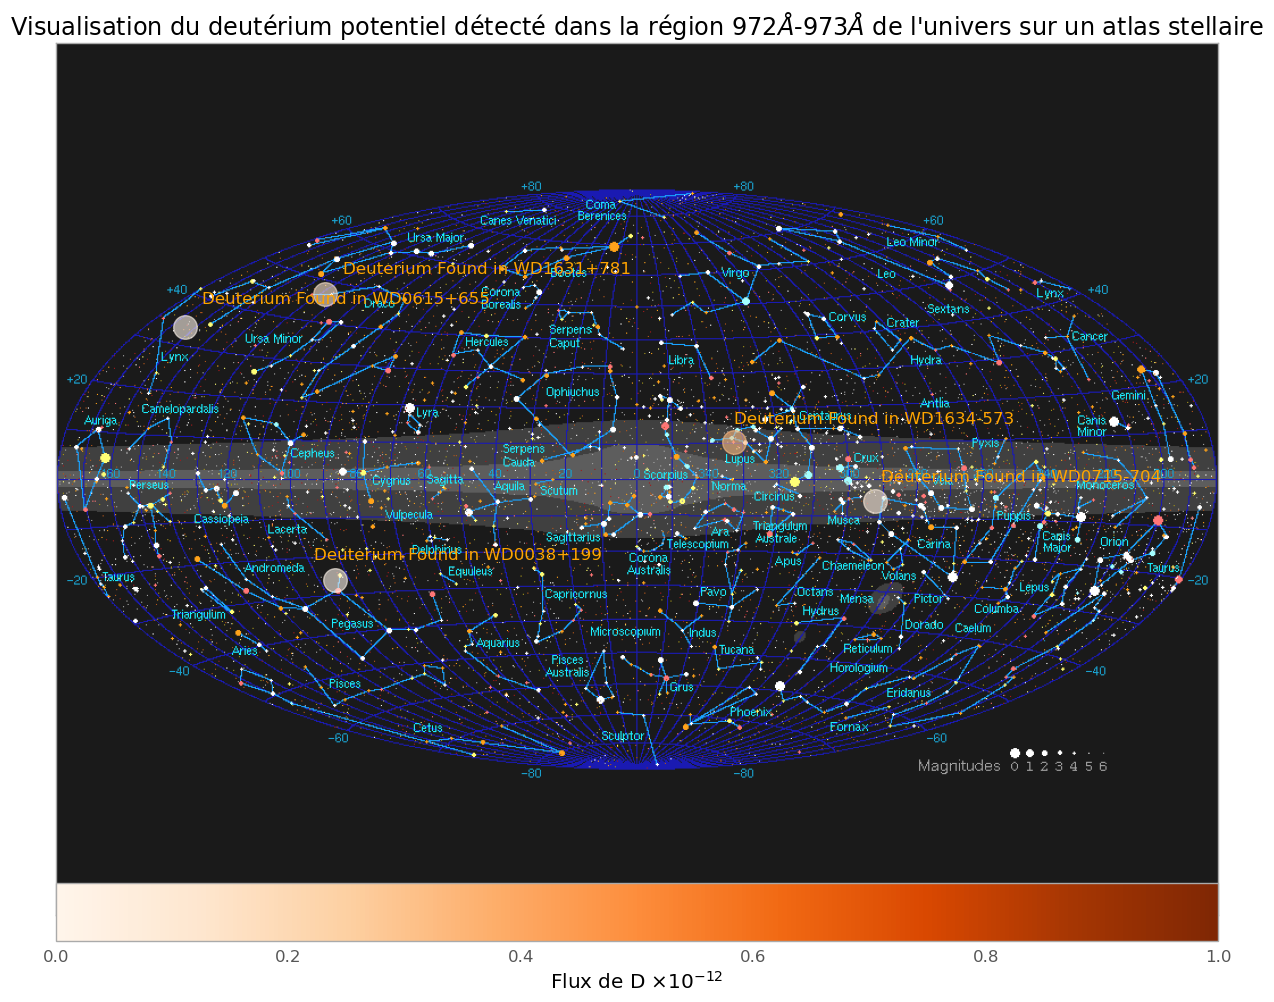

In [17]:
#Dossier contenant plusieurs images observant différents objets  
#Ici, les fichiers ont été extraits de leurs dossiers originaux et placés dans un nouveau dossier, ce qui facilite l'analyse.


fuse_folder = "FUSE Tutorial"
folder_path = os.path.realpath(fuse_folder)
dir_path = os.path.dirname(folder_path)

#Extraire les données des fichiers FITS et les stocker dans un seul dataframe
df = pd.DataFrame()

def extract_deterium(hdu):
    """ 
    Extract deuterium around the airglow emission 972.54 angstroms
    Inputs: 
    - hdu (astropy HDUList): the hdu of the FITS file

    Returns: 
    - d_df['WAVE'] (astropy column): wavelengths in the desired region
    - d_df['FLUX'] (astropy column): flux in the desired region
    """
    wave = Table(hdu[1].data)['WAVE']
    flux = Table(hdu[1].data)['FLUX']
    
    data_df = pd.DataFrame(np.transpose(np.array([wave, flux])), columns=['WAVE', 'FLUX'])

    d_df = data_df.query("WAVE > 1000 and WAVE < 1050")
    return (d_df['WAVE'], d_df['FLUX'])


def extract_info(hdu):
    """
    Extracts information from the FITS file
    Inputs:
    - hdu (astropy HDUList): the hdu of the FITS file

    Returns:
    - dict (dictonary): dictonary containing information about the object and the region of deuterium
    """
    data_table = Table(hdu[1].data)
    wave = data_table["WAVE"]
    flux = data_table["FLUX"]

    RA = hdu[0].header["RA_TARG"]
    DEC = hdu[0].header["DEC_TARG"]
    TargetName = hdu[0].header["TARGNAME"]
    wave_loc = np.where(flux == max(flux))[0][0]
    max_wave = wave[wave_loc]

    object = SkyCoord(RA, DEC, unit = 'deg')
    object_ra = (convert_coords(object.galactic.l.rad))
    object_dec = object.galactic.b.rad

    wave, flux = extract_deterium(hdu)
    
    dict = {"Max Wave": max_wave, "Max Flux": min(flux), "RA": object_ra, "DEC": object_dec, "Star Name": TargetName, "Wavelengths": wave, "Flux": flux}
    return (dict)

#Boucler à travers les fichiers et n'extraire que les informations des fichiers FITS.
directories = os.walk(dir_path)
for i in directories:
    if i[0] == dir_path:
        for file in i[2]:
            if file.endswith(".fit"):
                image = os.path.join(i[0], file)
                print (f"File Name: {file}")
                d = extract_info(fits.open(image))
                df = df._append(d, ignore_index= True)
print ("White Dwarf Dataframe")
print (df)

img = imread(star_atlas_url)
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(img, alpha = 0.9)

ax2 = fig.add_subplot(projection = "aitoff")

cmap = plt.colormaps["Oranges"]

#Créer un graphique de carte du ciel.
for i in df.index:
    ax2.plot(df["RA"][i], df["DEC"][i], marker = 'o', markersize = 17, color = cmap(df["Max Flux"][i] * 1e12), alpha = 0.6)
    ax2.text(df["RA"][i], df["DEC"][i] + 0.1, "Deuterium Found in " + df["Star Name"][i], color = "orange") #Add name of the star


fig.colorbar(plt.cm.ScalarMappable(cmap = cmap), ax = ax2, location = "bottom", orientation = "horizontal", label = "Flux de D $\\times 10^{-12}$")
plt.axis("off")
ax.grid(False)
ax.set_title("Visualisation du deutérium potentiel détecté dans la région 972$\\AA$-973$\\AA$ de l'univers sur un atlas stellaire")
ax.set_xticks([])
ax.set_yticks([])
plt.show()   


Notez que nous faisons l'hypothèse que le deutérium existera avec la même petite baisse dans tous les spectrogrammes à travers les différents objets. Pour plus de précision, il est recommandé d'examiner les spectrogrammes dans la région de 1020-1030 angströms et de vérifier visuellement.

## Lectures et références supplémentaires
Le document référencé pour déterminer les emplacements du deutérium
Williger, G. M, Oliveira, C., Hebrard, G., Dupuis, J., Dreizler, S., & Moos, W. H. (2005). The D/H Ratio toward PG 0038+199. *The Astrophysical Journal*. *625*(1). https://ui.adsabs.harvard.edu/link_gateway/2005ApJ...625..210W/doi:10.1086/429315     

Mesures supplémentaires pour le deutérium sur Terre
https://www.iaea.org/newscenter/news/what-is-deuterium  
https://energyeducation.ca/encyclopedia/Heavy_water

Sources des valeurs d'émission de la luminescence aérienne
https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001010000000000000000  
https://archive.stsci.edu/fuse/instrumenthandbook/chapter9.html

Lecture supplémentaire sur les splines cubiques
https://towardsdatascience.com/cubic-splines-the-ultimate-regression-model-bd51a9cf396d  

En savoir plus sur la mission FUSE  
L'agence spatiale canadienne (ASC): https://www.asc-csa.gc.ca/fra/satellites/fuse.asp
La NASA: https://science.nasa.gov/mission/fuse 
Astro Canada: https://astro-canada.ca/le_telescope_spatial_fuse-the_fuse_space_telescope-fra